**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Titanic

In [36]:
df = pd.read_csv("./titanic_data/train.csv")

In [44]:
print(df.shape)
df.head()

df = df.drop(["Name", "Ticket", 'Cabin'], axis=1)

(891, 12)


# Train Test Split

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
target = 'Survived'

# padrão 20% para teste
df_train, df_test = train_test_split(df,
                                     test_size = 0.3,
                                     random_state=75)
df_test, df_valid = train_test_split(df_test,
                                     test_size = 0.5,
                                     random_state=75)


print("df.shape:      ",df.shape)
print("df_train.shape:",df_train.shape)
print("df_test.shape: ",df_test.shape)


X_train = df_train.drop(target, axis=1) # drop labels for training set
y_train = df_train[target].copy()

X_test = df_test.drop(target, axis=1) # drop labels for training set
y_test = df_test[target].copy()

X_valid = df_valid.drop(target, axis=1) # drop labels for training set
y_valid = df_valid[target].copy()


print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

df.shape:       (891, 9)
df_train.shape: (623, 9)
df_test.shape:  (134, 9)
X_train.shape: (623, 8)
y_train.shape: (623,)


# Teste HistGradientBoostingClassifier and HalvingRandomSearchCV

When using Gradient Descent, you should ensure that all features
have a **similar scale** (e.g., using Scikit-Learn’s StandardScaler
class), or else it will take much longer to converge.

In [52]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [53]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
261,262,3,male,3.0,4,2,31.3875,S
180,181,3,female,NaN,8,2,69.5500,S
440,441,2,female,45.0,1,1,26.2500,S
68,69,3,female,17.0,4,2,7.9250,S
315,316,3,female,26.0,0,0,7.8542,S


In [169]:
# numeric_transformer
numeric_features = X_train.select_dtypes(include='number').columns # all numericals
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# categorical transformer
categorical_features = X_train.select_dtypes(include='object').columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
        # MUITA Atenção aos argumentos do ColumnTransformer:
        remainder='passthrough',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None,
        verbose=False)

# GridSearch | RandomizedSearchCV
param_grid = [{"learning_rate" : [1] # Use 1 for no shrinkage.
               }, 
             ]
classifier = GradientBoostingClassifier() # HistGradientBoostingClassifier()

grid_search = GridSearchCV( #HalvingRandomSearchCV(
                            classifier,
                            param_grid = param_grid, #param_distributions=param_grid,
                            cv=5,
                            verbose=False,
                            refit=True)

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', preprocessor),
    ('grid_search', grid_search)
])

In [170]:
prepare_select_and_predict_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                              

# cross_val_predict

In [171]:
from sklearn.model_selection import cross_val_predict

y_scores     = cross_val_predict(prepare_select_and_predict_pipeline, X_train, y_train, cv=5, method='predict_proba')
y_train_pred = cross_val_predict(prepare_select_and_predict_pipeline, X_train, y_train, cv=5, method='predict')

In [172]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[312,  62],
       [ 66, 183]])

# Precision Recall Curve

In [173]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

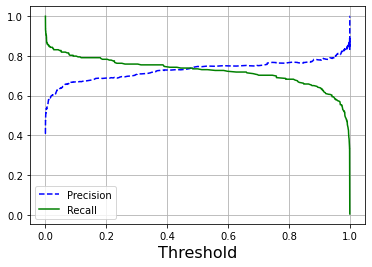

In [174]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

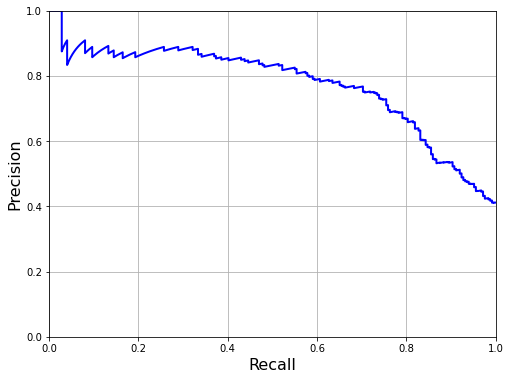

In [175]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC_AUC

In [176]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores[:,1])

0.8310568477117025

## Tresholds

In [177]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores[:,1])

# Best treshold

In [178]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

y_train_pred_treshold = np.where(y_scores[:,1] >= optimal_threshold,1,0)

0.500102770867019


In [179]:
tpr_opt = tpr[np.argmax(thresholds <= optimal_threshold)]
fpr_opt = fpr[np.argmax(thresholds <= optimal_threshold)]

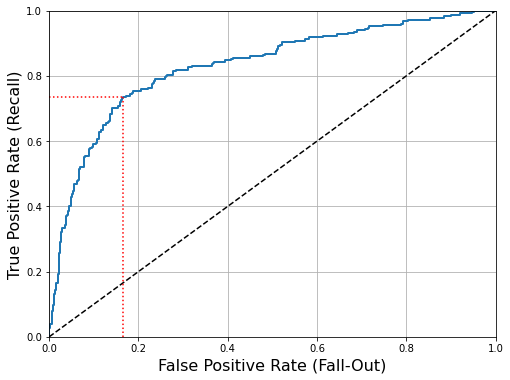

In [180]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([fpr_opt, fpr_opt], [0., tpr_opt], "r:")   # Not shown
plt.plot([0., fpr_opt], [tpr_opt, tpr_opt], "r:")   # Not shown

plt.show()

### Comparando diferentes tresholds

In [181]:
confusion_matrix(y_train, y_train_pred)

array([[312,  62],
       [ 66, 183]])

In [182]:
confusion_matrix(y_train, y_train_pred_treshold)

array([[312,  62],
       [ 66, 183]])

# Importance

In [183]:
#features names
num_ar_ =  numeric_features

cat_ar_ = prepare_select_and_predict_pipeline['preparation'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

feature_names = np.r_[num_ar_, cat_ar_]

<ipython-input-184-43e9032b9e14>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


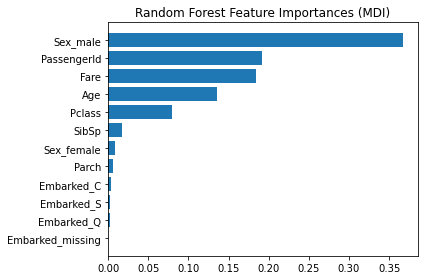

In [184]:
importances = (prepare_select_and_predict_pipeline.named_steps['grid_search'].best_estimator_.feature_importances_)
sorted_idx = importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

<br>
<br>
<br>
<br>
<br>

---

# Permutation importance
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
- **Permutation importance is calculated after a model has been fitted**.
    - 1: Get a trained model.
    - 2: Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
    - 3: Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.



In [185]:
from sklearn.inspection import permutation_importance

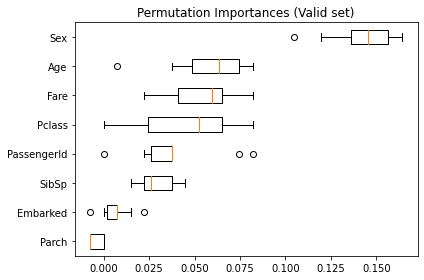

In [186]:
result = permutation_importance(prepare_select_and_predict_pipeline, X_valid, y_valid, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (Valid set)")
fig.tight_layout()
plt.show()

In [187]:
pd.DataFrame({"Features" : X_test.columns,
              "importances_mean" : result['importances_mean'],
              "importances_std" : result['importances_std'] }).sort_values('importances_mean', ascending=False)

,Features,importances_mean,importances_std
2,Sex,0.143284,0.018522
3,Age,0.058955,0.022251
6,Fare,0.053731,0.019403
1,Pclass,0.045522,0.024627
0,PassengerId,0.038806,0.022831
4,SibSp,0.028358,0.009900
7,Embarked,0.006716,0.007791
5,Parch,-0.004478,0.003656


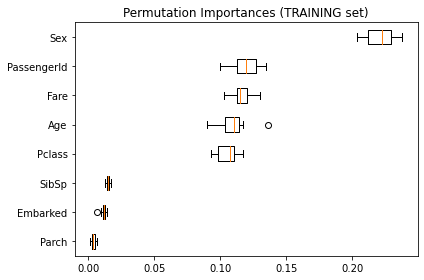

In [188]:
result = permutation_importance(prepare_select_and_predict_pipeline, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (TRAINING set)")
fig.tight_layout()
plt.show()

In [189]:
pd.DataFrame({"Features" : X_test.columns,
              "importances_mean" : result['importances_mean'],
              "importances_std" : result['importances_std'] }).sort_values('importances_mean', ascending=False)

,Features,importances_mean,importances_std
2,Sex,0.220867,0.011056
0,PassengerId,0.118138,0.011467
6,Fare,0.116693,0.007865
3,Age,0.109791,0.012016
1,Pclass,0.105457,0.007632
4,SibSp,0.015249,0.001294
7,Embarked,0.011717,0.002276
5,Parch,0.003852,0.001471


Quanto maior a diferença da importancia da variavel no treino em relação ao teste, maior é a probabilidade daquela variável estar sendo usada para overfitar o modelo

<br>
<br>
<br>
<br>
<br>

---

# Partial Dependence Plots
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html
- **While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.**

    - Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?
    - Are predicted health differences between two groups due to differences in their diets, or due to some other factor?
    
    
- Like permutation importance, **partial dependence plots are calculated after a model has been fit.**



- PLOT
    - https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_partial_dependence_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-partial-dependence-visualization-api-py

# 1d

Computing partial dependence plots...


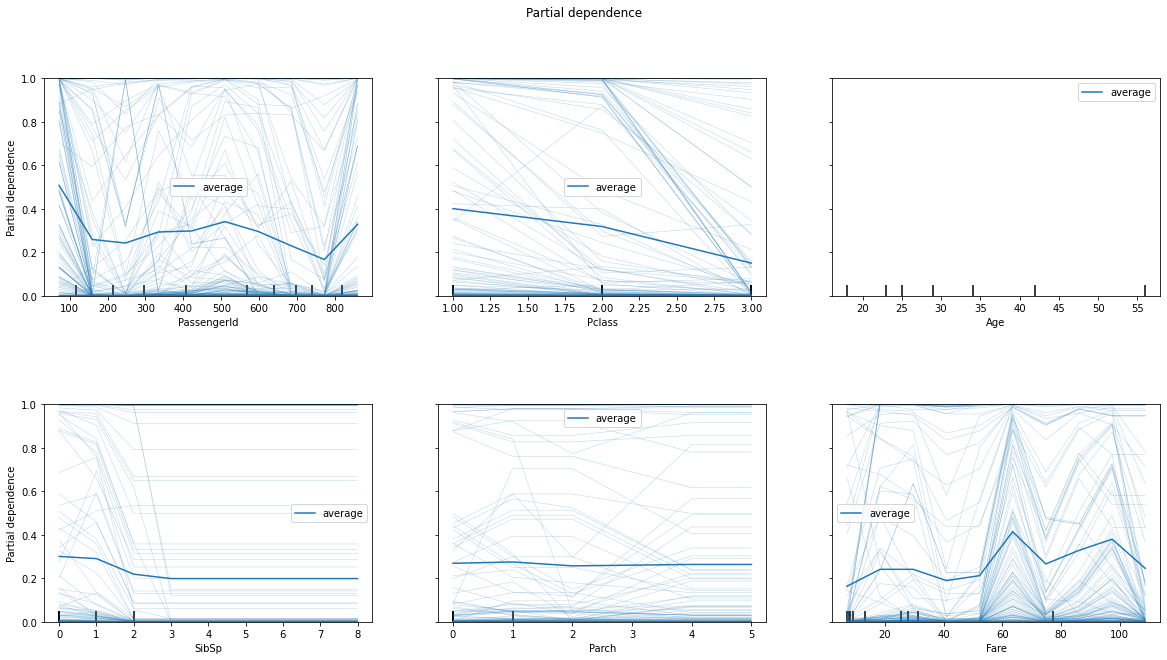

In [245]:
import matplotlib.pyplot as plt
import time as time
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

print('Computing partial dependence plots...')
features = numeric_features
display = plot_partial_dependence(
       prepare_select_and_predict_pipeline, X_valid, features, kind="both", subsample=200, method='brute', # Brute apenas com o gradientclassifier
       n_jobs=3, grid_resolution=10, random_state=0
)
display.figure_.suptitle(
    'Partial dependence'
)
display.figure_.set_size_inches((20,10))
display.figure_.subplots_adjust(hspace=0.5)

# 2d

Computing partial dependence plots...


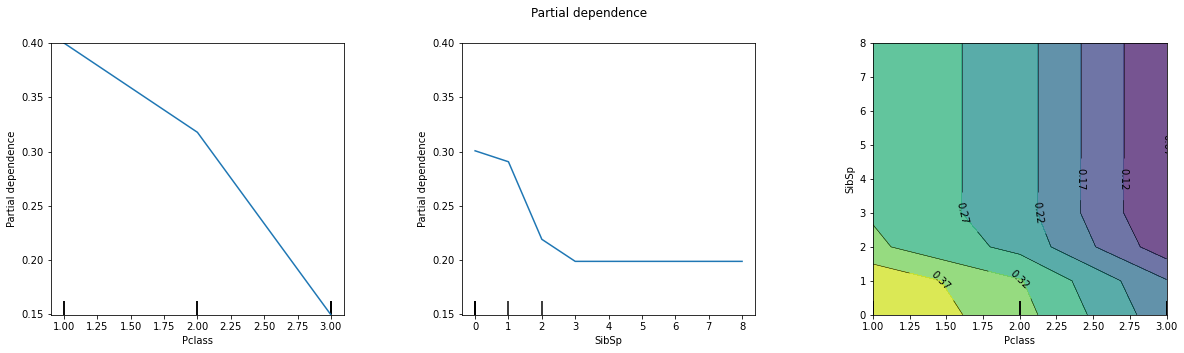

In [287]:
features = ['Pclass', 'SibSp', ('Pclass', 'SibSp')]
print('Computing partial dependence plots...')
_, ax = plt.subplots(ncols=3, figsize=(9, 4))

display = plot_partial_dependence(
    prepare_select_and_predict_pipeline, X_valid, features, kind='average', n_jobs=3, grid_resolution=20,
    ax=ax,)

display.figure_.suptitle('Partial dependence ')

display.figure_.set_size_inches((20,5))

display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

<br>
<br>
<br>
<br>
<br>

---

# Shap Values
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html
- **SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature**

    - A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
    - A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

## Individual Predictions

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [345]:
# numeric_transformer
numeric_features = X_train.select_dtypes(include='number').columns # all numericals
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# categorical transformer
categorical_features = X_train.select_dtypes(include='object').columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
        # MUITA Atenção aos argumentos do ColumnTransformer:
        remainder='passthrough',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None,
        verbose=False)

# GridSearch | RandomizedSearchCV
param_grid = [{"min_samples_split" : [2,8,16] # Use 1 for no shrinkage.
               }, 
             ]
classifier = DecisionTreeClassifier() # HistGradientBoostingClassifier()

grid_search = GridSearchCV( #HalvingRandomSearchCV(
                            classifier,
                            param_grid = param_grid, #param_distributions=param_grid,
                            cv=5,
                            verbose=False,
                            refit=True)

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', preprocessor),
    ('grid_search', grid_search)
])

prepare_select_and_predict_pipeline.fit(X_train, y_train)

mymodel = prepare_select_and_predict_pipeline.named_steps['grid_search'].best_estimator_


In [358]:
data_for_prediction = prepare_select_and_predict_pipeline.named_steps['preparation'].transform(X_valid)

#features names
num_ar_ =  numeric_features

cat_ar_ = prepare_select_and_predict_pipeline['preparation'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

feature_names = np.r_[num_ar_, cat_ar_]

data_for_prediction = pd.DataFrame(data_for_prediction, columns = feature_names)

In [359]:
data_for_prediction

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,-0.546920,-1.534888,-0.399403,-0.490141,-0.487759,0.975280,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.475926,0.852716,0.150334,0.504510,0.727736,-0.254458,1.0,0.0,0.0,0.0,1.0,0.0
2,1.093828,-0.341086,0.071800,2.493814,-0.487759,-0.245132,1.0,0.0,0.0,0.0,1.0,0.0
3,0.596871,-0.341086,-0.399403,1.499162,0.727736,-0.127328,1.0,0.0,0.0,0.0,1.0,0.0
4,1.716997,0.852716,-0.320869,-0.490141,-0.487759,-0.519025,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
129,1.003114,0.852716,-0.320869,-0.490141,-0.487759,-0.505444,0.0,1.0,0.0,1.0,0.0,0.0
130,1.011002,-0.341086,0.778604,-0.490141,-0.487759,-0.146962,0.0,1.0,0.0,0.0,1.0,0.0
131,1.101716,-0.341086,-0.320869,0.504510,-0.487759,-0.146962,0.0,1.0,0.0,0.0,1.0,0.0
132,-1.465897,0.852716,-0.085268,-0.490141,-0.487759,-0.499391,0.0,1.0,0.0,0.0,1.0,0.0


In [360]:
explainer = shap.TreeExplainer(mymodel)

In [361]:
shap_values = explainer.shap_values(data_for_prediction)

In [362]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)